# Identifikation von noch vorhandenem Wissen im Linux-Kernel


### Der Patient

#### Linux

* Betriebsystem-Kernel
* Hat verschiedene Treiberkomponenten
* Fast ausschließlich in C geschrieben
* Entwickelt von über 800.000 Entwicklern

### I. Idee (1/2)

<b>Fragestellung</b>
* Gibt es besonders alte Komponenten (No-Go-Areas)?


### I. Idee (2/2)
#### Umsetzung
* Werkzeuge: Jupyter, Python, pandas, matplotlib
* Datenquelle: Git Blame Log


**Meta-Ziel:** Grundfunktionen anhand eines einfachen Show-Cases sehen.

<b>Git Blame Log</b>
<div align="center">
    <img src ="resources/linux_1.gif" align="center"/>
</div>

<b>Git Blame Log</b>
<div align="center">
    <img src ="resources/linux_2.gif" align="center"/>
</div>

<b>Git Blame Log</b>
<div align="center">
    <img src ="resources/linux_3.gif" align="center"/>
</div>

### II. Datenbeschaffung
*Wir laden Git Blame Daten aus einer CSV-Datei*

In [1]:
import pandas as pd

log = pd.read_csv("dataset/linux_blame_log.csv.gz")
log.head()

,path,author,timestamp,line
0,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,1448528085000000000,1
1,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,1448528085000000000,2
2,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,1448528085000000000,3
3,drivers/scsi/bfa/bfad_drv.h,Jing Huang,1253753175000000000,4
4,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,1448528085000000000,5


*Was haben wir hier eigentlich?*

In [2]:
log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5665947 entries, 0 to 5665946
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   path       object
 1   author     object
 2   timestamp  int64 
 3   line       int64 
dtypes: int64(2), object(2)
memory usage: 172.9+ MB


<b>1</b> **DataFrame** (~ programmierbares Excel-Arbeitsblatt), <b>4</b> **Series** (= Spalten), <b>5665947</b> **Rows** (= Einträge)

### III. Bereinigen
* Daten sind oft nicht so, wie man sie braucht
* Datentypen passen teilweise noch nicht

*Wir wandeln die Zeitstempel um*

In [3]:
log['timestamp'] = pd.to_datetime(log['timestamp'])
log.head()

,path,author,timestamp,line
0,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,1
1,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,2
2,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,3
3,drivers/scsi/bfa/bfad_drv.h,Jing Huang,2009-09-24 00:46:15,4
4,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,5


### IV. Anreichern

* Vorhandenen Daten noch zusätzlich mit anderen Datenquellen verschneiden
* Aber auch: Teile aus vorhanden Daten extrahieren

=> Dadurch werden mehrere <b>Perspektiven</b> auf ein Problem möglich

*Wir berechnen uns das Alter jeder Codezeilenänderung*

In [4]:
log['age'] = pd.Timestamp('today') - log['timestamp']
log.head()

,path,author,timestamp,line,age
0,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,1,1760 days 12:28:55.621148
1,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,2,1760 days 12:28:55.621148
2,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,3,1760 days 12:28:55.621148
3,drivers/scsi/bfa/bfad_drv.h,Jing Huang,2009-09-24 00:46:15,4,4014 days 20:37:25.621148
4,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,5,1760 days 12:28:55.621148


*Wir ordnen jeder Zeilenänderung einer Komponente zu*

In [5]:
log['component'] = log['path'].str.split("/").str[:2].str.join(":")
log.head()

,path,author,timestamp,line,age,component
0,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,1,1760 days 12:28:55.621148,drivers:scsi
1,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,2,1760 days 12:28:55.621148,drivers:scsi
2,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,3,1760 days 12:28:55.621148,drivers:scsi
3,drivers/scsi/bfa/bfad_drv.h,Jing Huang,2009-09-24 00:46:15,4,4014 days 20:37:25.621148,drivers:scsi
4,drivers/scsi/bfa/bfad_drv.h,Anil Gurumurthy,2015-11-26 08:54:45,5,1760 days 12:28:55.621148,drivers:scsi


<br/> <small><i>String-Operationen...die dauern. Gibt aber diverse Optimierungsmöglichkeiten!</i></small>

### V. Aggregieren
* Vorhandene Daten sind oft zu viel für manuelle Sichtung
* Neue Einsichten über Problem aber oft auf hoher Flugbahn möglich

*Wir fassen nach Komponenten zusammen und arbeiten mit der jeweils jüngsten Zeilenänderung weiter*

In [6]:
age_per_component = log.groupby("component")['age'].min().sort_values().dt.days
age_per_component.head()

component
drivers:scsi    893
drivers:i2c     893
drivers:net     893
drivers:of      893
drivers:pci     894
Name: age, dtype: int64

### IV. Visualisieren
* Grafische Darstellung geben Analysen den letzten Schliff
* Probleme können Außenstehenden visuell dargestellt besser kommuniziert werden

*Wir bauen ein Diagramm mit min. Alter pro Komponente*

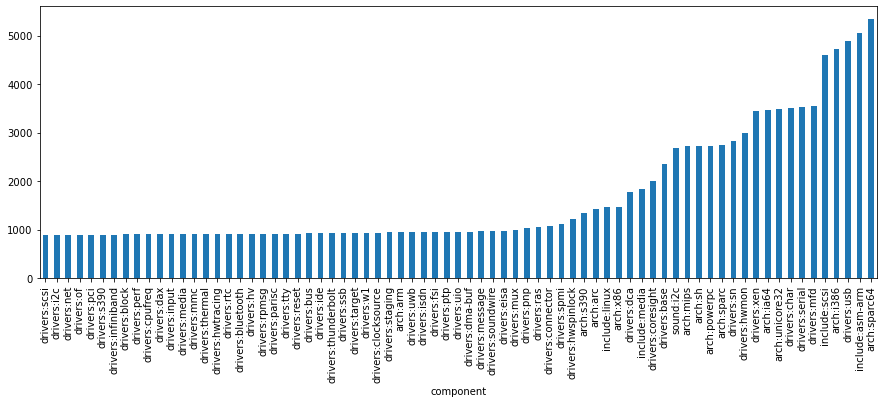

In [7]:
age_per_component.plot.bar(figsize=[15,5], rot=90);

# Vielen Dank! Fragen?

<b>Markus Harrer</b><br/>
innoQ Deutschland GmbH
  
markus.harrer@innoq.com 

`@feststelltaste`